In [1]:
#%%capture
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import scipy as sc, pandas as pd, seaborn as sns
import gpflow as gp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [2]:
f64 = gp.utilities.to_default_float
survey_max_rank = 10
survey_min_rank = -30
rank_variance = 2
data_point_threshold = 1
linear_regression_threshold = 6
gpr_likelihood_variance_for_filling = 0.03
gpr_likelihood_variance_for_ranking = 0.01
gpr_ls_prior = 30
gpr_ls_prior_delta = 10
outlier_rank_diff = 8
sns.set()

# Results of the go rank survey
Following are some visualizations and tables based on the data gathered in the new Mar-Jun 2020 survey [here](https://docs.google.com/forms/d/e/1FAIpQLSekyWO_8TtE1ODGJOKVOee0WNBWzOSnJs0ZqtQ93l36JIJmYw/viewform?usp=sf_link). The raw data can be accessed [here](https://github.com/NTUST-MITLAB/go-rank-survey-2020/blob/master/Go%20rank%20survey%20Mar%20to%20Jun%202020%20en.csv) in the form of a .csv file. 

The plots were made by mapping kyu ranks to negative integers, so that 1d corresponds to 0 (i.e. 1k -> -1, 2d -> 1).
The tables are based on OGS ranks.

In [3]:
data = pd.read_csv('Go rank survey Mar to Jun 2020 en.csv')

In [4]:
#data.head()

## How many responses were given for each server.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Time Stamp      190 non-null    object 
 1   OGS             118 non-null    object 
 2   KGS             88 non-null     object 
 3   DGS             9 non-null      object 
 4   IGS             77 non-null     object 
 5   Foxwq           94 non-null     object 
 6   Tygem           78 non-null     object 
 7   WBaduk          27 non-null     object 
 8   GoQuest_rank    12 non-null     object 
 9   GoQuest_rating  13 non-null     float64
 10  AGA             23 non-null     object 
 11  EGF             51 non-null     object 
 12  Korea           1 non-null      object 
 13  China           2 non-null      object 
 14  Japan           7 non-null      object 
 15  Taiwan          34 non-null     object 
dtypes: float64(1), object(15)
memory usage: 23.9+ KB


In [6]:
def mapping(raw_rank):
    try:
        t = raw_rank[-1]
    except:
        return raw_rank
    if t == 'k':
        n = -int(raw_rank[:-1])
    else:
        n = int(raw_rank[:-1])-1
    return n
numerical_rank = data.iloc[:,1:].copy()
numerical_rank = numerical_rank.applymap(mapping)
numerical_rank = numerical_rank.iloc[:,((numerical_rank.shape[0]-numerical_rank.isna().sum())>data_point_threshold).values]
numerical_rank.dropna().shape
numerical_rank_predict = numerical_rank
#numerical_rank

# Outlier auto-detection
Outliers are detected automatically by finding overall rank difference more than 7 ranks across all platforms. However, due to kyu ranks often flucturating, and GoQuest rank is very unique, hence only records with rank difference more than 7 and has a rank over dan level (excluding GoQuest rank) would be considered outliers.

In [7]:
# outliers detection, rank difference across platform greater than 7
#print("maximum value in each columns (dan rank -1, negative value is kyu)")
#print(numerical_rank.max())
#print("\nminimum value in each columns (dan rank -1, negative value is kyu)")
#print(numerical_rank.min())
numerical_rank_cut = numerical_rank.drop(['GoQuest_rating'], axis=1)
max_rank_all = numerical_rank_cut.max().max()
min_rank_all = numerical_rank_cut.min().min()
print("\nmaximum rank in the survey is {}d, minimum rank is {}k".format(int(max_rank_all+1), int(-min_rank_all)))

rank_diff_row = numerical_rank_cut.max(axis=1) - numerical_rank_cut.min(axis=1)

numerical_rank_cut = numerical_rank.drop(['GoQuest_rank','GoQuest_rating'], axis=1)
rank_diff_row = numerical_rank_cut.max(axis=1) - numerical_rank_cut.min(axis=1)
possible_outlier_row = rank_diff_row[(numerical_rank_cut.max(axis=1)-numerical_rank_cut.min(axis=1))>outlier_rank_diff]
print("\nlist of possible outliers with rank difference greater than {}".format(int(outlier_rank_diff)))
data.iloc[possible_outlier_row.index,:]



maximum rank in the survey is 9d, minimum rank is 27k

list of possible outliers with rank difference greater than 8


Time Stamp  OGS KGS  DGS  IGS Foxwq Tygem WBaduk GoQuest_rank  \
33   2020/3/21 PM 9:05:37  10k  6k  NaN  10k    8k   18k    15k           5k   
35   2020/3/21 PM 9:41:18   9k  5k  NaN  10k    9k   10k    15k          NaN   
103  2020/3/24 AM 8:22:37  10k  6k  NaN  NaN    1d   NaN    NaN          NaN   

     GoQuest_rating  AGA  EGF Korea China Japan Taiwan  
33              NaN  NaN  NaN   NaN   NaN   NaN    NaN  
35              NaN  NaN  10k   NaN   NaN   NaN    NaN  
103             NaN  NaN  NaN   NaN   NaN   NaN    NaN

In [8]:
#finding possible outliers, excluding player ranks below dan level
outlier_list = numerical_rank_cut.iloc[possible_outlier_row.index,:].max(axis=1)
outlier_index = data.iloc[outlier_list[outlier_list>=0].index,:].index

print("outliers index in the csv file row {} total {} entries".format(outlier_index.values+2, int(outlier_index.shape[0])))
numerical_rank.drop(outlier_index, inplace=True)
#numerical_rank.drop([103,146,], inplace=True)

outliers index in the csv file row [105] total 1 entries


## Pair-wise plotting of server ranks with linear regression

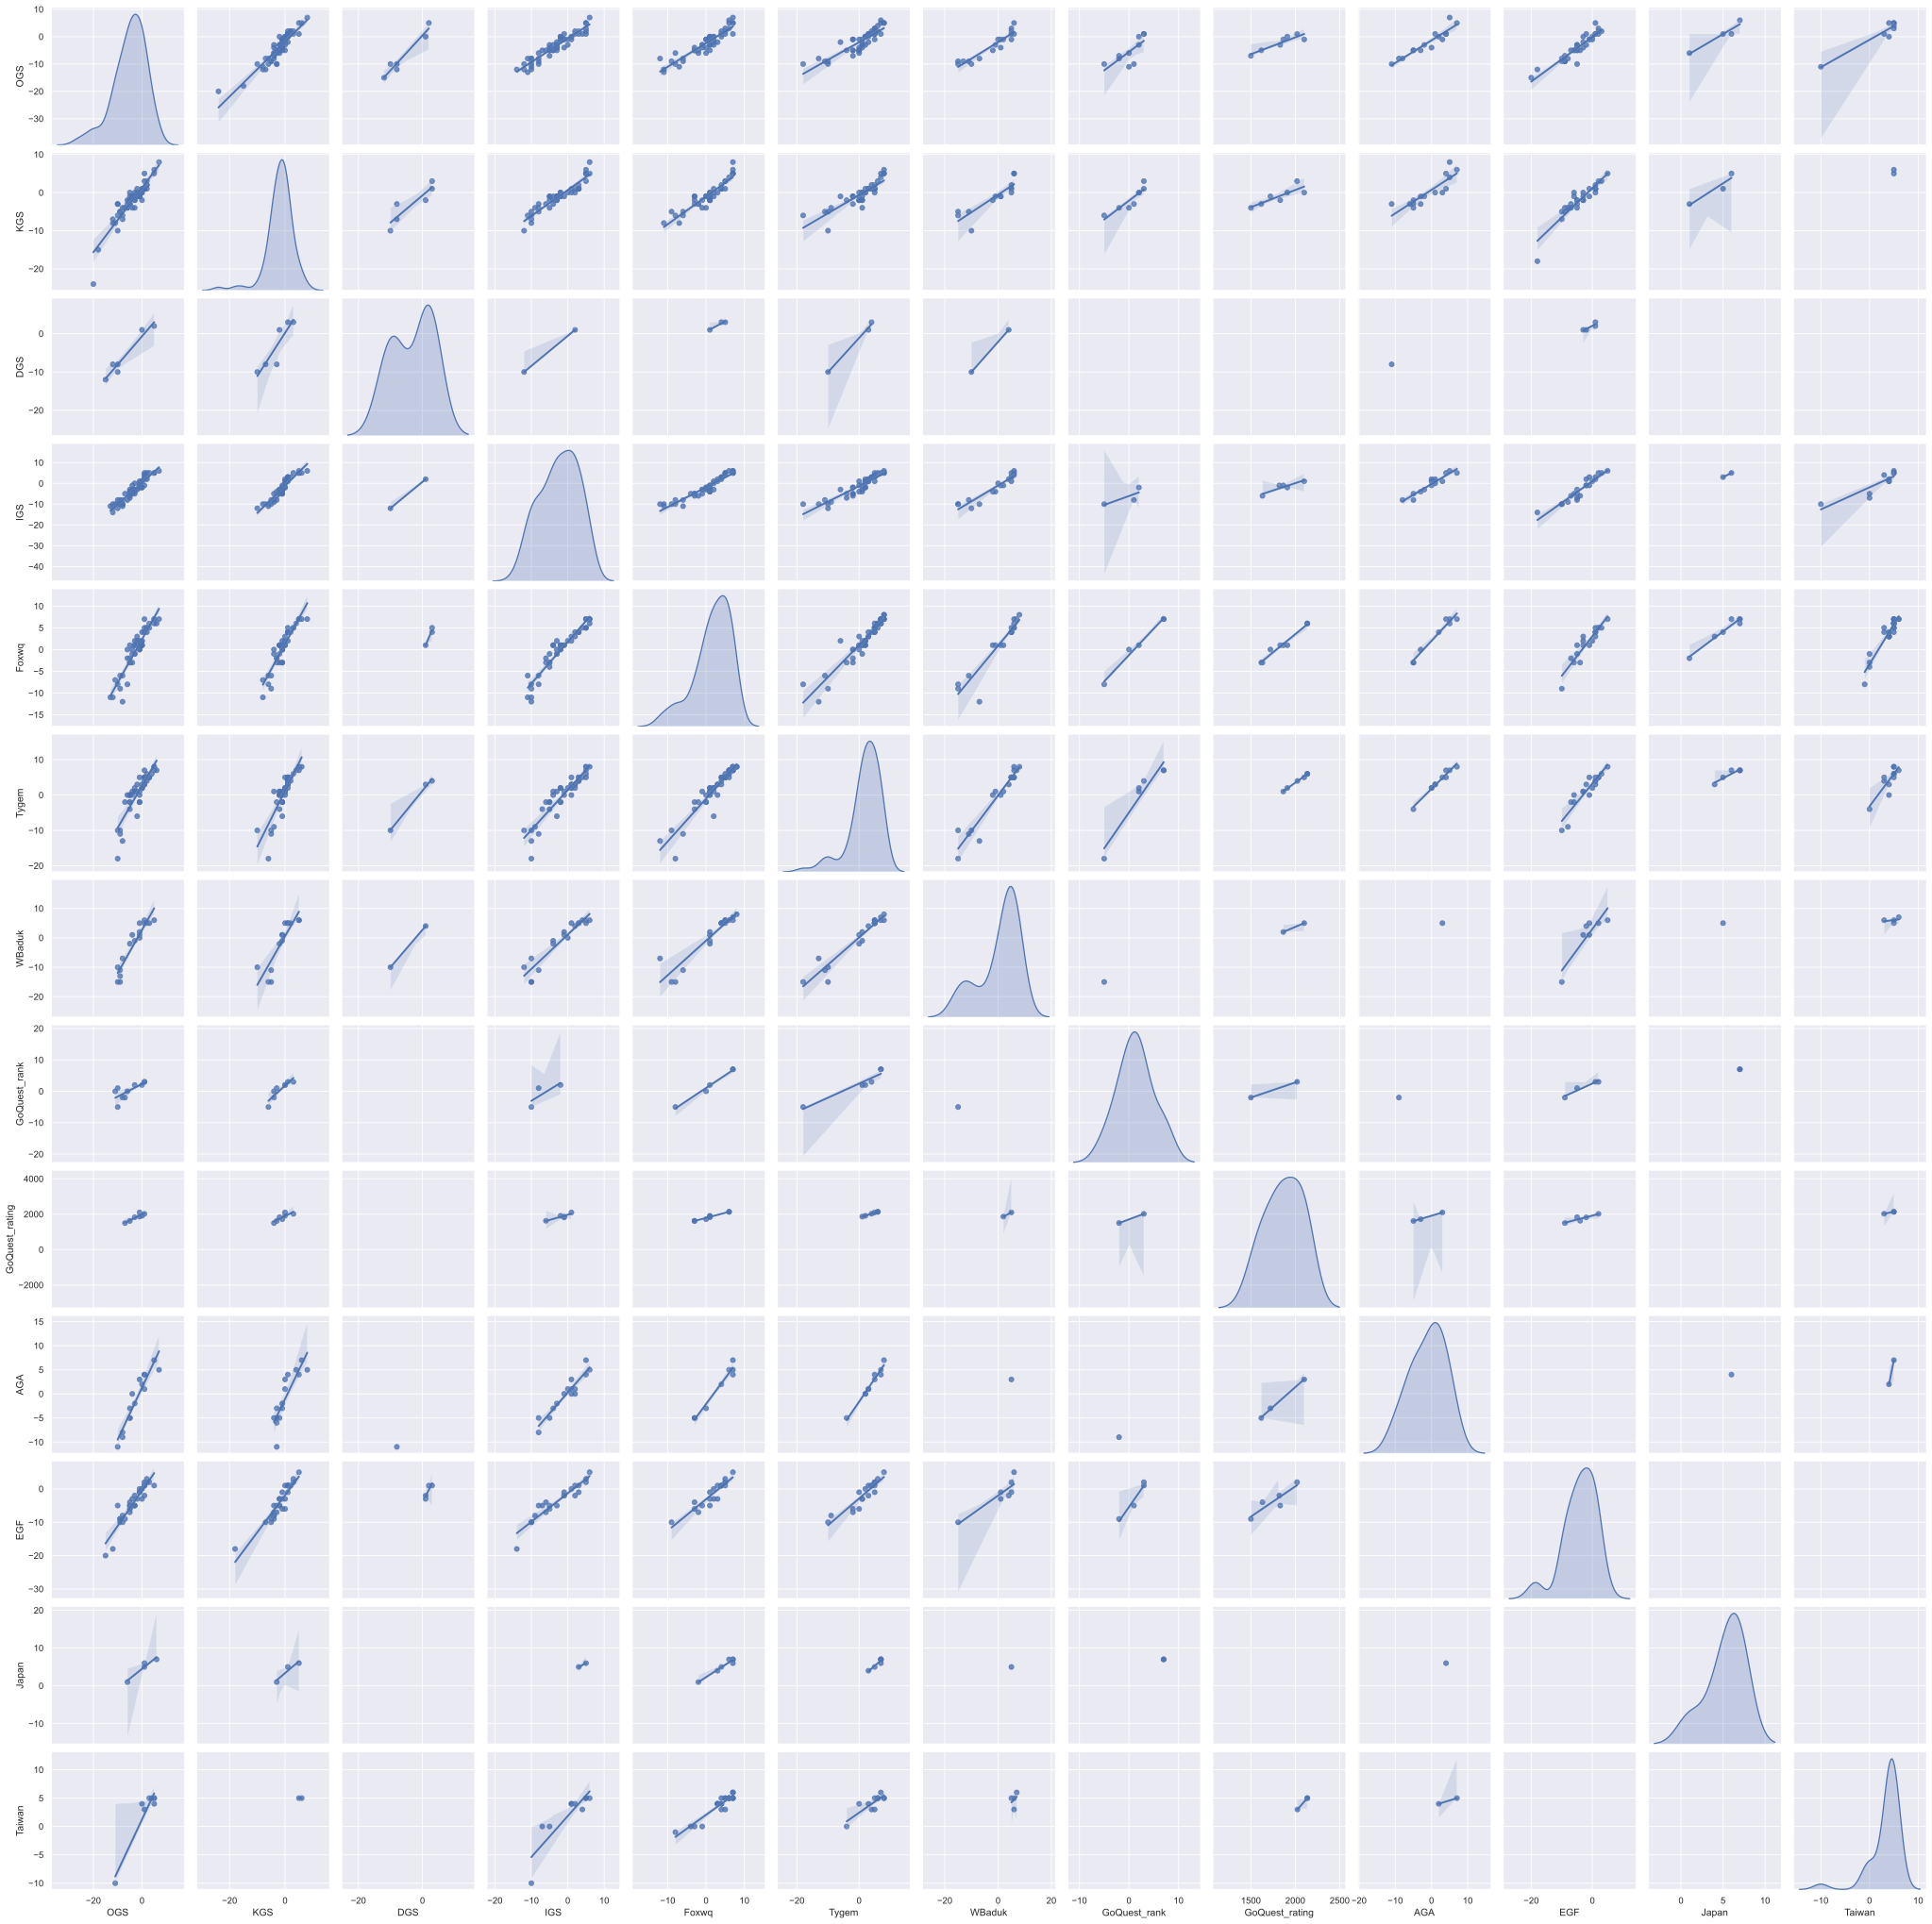

In [9]:
#%%capture --no-display
sns_pairplot = sns.pairplot(numerical_rank.iloc[:,((numerical_rank.shape[0]-numerical_rank.isna().sum())>linear_regression_threshold).values], diag_kind='kde', kind='reg');
sns_pairplot.savefig("rank-pairplot.png")

In [10]:
def plot(m, X, Y, lo=survey_min_rank, hi=survey_max_rank, xlabel='X', ylabel='Y', sigma=2):
    lo = X.min()-abs(X.min()*.5/2)
    hi = X.max()+abs(X.max()*.5)
    xx = np.linspace(lo, hi, 1000)[:,None]
    mean, var = m.predict_y(xx)
    p=plt.figure()#figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - sigma*np.sqrt(var[:,0]), mean[:,0] + sigma*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(lo, hi)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p


In [11]:
def get_ranks_on_server(rank_start=min_rank_all, rank_end=max_rank_all, fro='OGS', to='Tygem', lo=survey_min_rank, hi=survey_max_rank, k=gp.kernels.RBF, meanf=gp.mean_functions.Zero, prior=(10,1e9), sigma=2):
    x=numerical_rank[[fro,to,]].dropna().values
    ranks = np.arange(rank_start, rank_end)
    #with gp.defer_build():
    X=x.T[0].reshape(-1, 1)
    Y=x.T[1].reshape(-1, 1)
    data = (X, Y)
    kern=k(1)
    mean_function=meanf()
    m=gp.models.GPR(data, kern, mean_function)
    
    m.kernel.lengthscales.prior = tfd.Gamma(f64(prior[0]), f64(prior[1]))
    #m.compile()
    #gp.utilities.print_summary(m, fmt="notebook")
    gp.config.set_default_summary_fmt("notebook")
    m.likelihood.variance.assign(gpr_likelihood_variance_for_ranking)
    #gp.utilities.print_summary(m.likelihood)
    m.trainable_parameters
    
    optz = gp.optimizers.Scipy()
    optz.minimize(m.training_loss, variables=m.trainable_variables, options=dict(disp=True, maxiter=1000))
    #gp.train.ScipyOptimizer(tol=1e-7).minimize(m)
    print('\n processing {}'.format(to))
    print(m.kernel.lengthscales)
    mean, var = m.predict_y(f64(ranks[:,None]))
    return mean,(mean[:,0] - sigma*np.sqrt(var[:,0]), mean[:,0] + sigma*np.sqrt(var[:,0])), plot(m, x.T[0], x.T[1], lo=lo, hi=hi, xlabel=fro, ylabel=to, sigma=sigma)

In [12]:
def fillna(a='OGS', b='KGS'):
    #with gp.defer_build():
    #print("GPR model process for {}".format(a))
    X=numerical_rank[[a,b]].dropna()[a].values[:,None]
    Y=numerical_rank[[a,b]].dropna()[b].values[:,None]
    data = (X, Y)
    kern=gp.kernels.RBF(1)
    mean_function=gp.mean_functions.Linear()
    #noise_variance=0.01
    m=gp.models.GPR(data, kern, mean_function)
    #m.kern.lengthscales.prior = gp.priors.Gaussian(10,10)
    #m.compile()
 
    #gp.utilities.print_summary(m, fmt="notebook")
    gp.config.set_default_summary_fmt("notebook")
    m.likelihood.variance.assign(gpr_likelihood_variance_for_filling)
    #gp.utilities.print_summary(m.likelihood)
    #gp.utilities.set_trainable(m.kernel.kernels[1].variance, True)
    m.trainable_parameters

    optz = gp.optimizers.Scipy()
    optz.minimize(m.training_loss, variables=m.trainable_variables, options=dict(disp=True, maxiter=1000))
    xx=numerical_rank[numerical_rank[a].notna()&numerical_rank[b].isna()][a].values[:,None]
    yy=m.predict_y(xx)[0].numpy()
    numerical_rank_predict.loc[numerical_rank[a].notna()&numerical_rank[b].isna(), b]=yy.ravel()

    #X.loc[X[a].notna()&X[b].isna(), b] = yy.ravel()

In [13]:
#%%capture
sorted_cols = sorted(numerical_rank.columns, key=lambda x: numerical_rank[x].count(), reverse=True)
print(sorted_cols)
    

['OGS', 'Foxwq', 'KGS', 'Tygem', 'IGS', 'EGF', 'Taiwan', 'WBaduk', 'AGA', 'GoQuest_rating', 'GoQuest_rank', 'DGS', 'Japan', 'China']


In [14]:
for c in [x for x in sorted_cols if x!='OGS']:
    #fillna('MIX',c)
    fillna(c,'OGS')

In [15]:
def n_to_rank(n):
    if n>survey_max_rank+rank_variance:
        return int(round(n))
    n=int(round(n))
    if n<0:
        return f'{abs(n)}k'
    else:
        return f'{abs(n+1)}d'

In [16]:
def n_to_rank_float(n):
    if n>survey_max_rank+rank_variance:
        return round(n,1)
    n=round(n,1)
    if n<0:
        return f'{abs(n)}k'
    else:
        return f'{abs(n+1)}d'

In [17]:
def get_rank_tables(against='KGS', lo=min_rank_all, hi=max_rank_all, prior=(10,1e6)):
    meantable = pd.DataFrame()
    stdtable = pd.DataFrame()
    combinedtable = pd.DataFrame()
    for s in numerical_rank_predict.drop(columns=[against,]).columns:
        mean,ci,p = get_ranks_on_server(
            lo,
            hi,
            against,
            s,
            k=lambda x: gp.kernels.RBF(1),
            meanf=gp.mean_functions.Linear,
            prior=prior,
            sigma=1,
        )
        #print("processing {}".format(s))
        #print(mean)
        #for x,_ in enumerate(mean):
        #    print(mean[x][0].numpy())
        #print(ci[0])
        #print(ci[1])
        #for x,_ in enumerate(ci[0]):
        #    print(ci[0][x].numpy())
        #    print(ci[1][x].numpy())
        meantable.insert(loc=0, column=s, value=[f'{n_to_rank(mean[x][0].numpy())}' for x,_ in enumerate(mean)])
        stdtable.insert(loc=0, column=s, value=[f'{n_to_rank(ci[0][x].numpy())} - {n_to_rank(ci[1][x].numpy())}' for x,_ in enumerate(ci[0])])
        combinedtable.insert(loc=0, column=s, value=[f'{n_to_rank_float(mean[x][0].numpy())} ± {round(ci[1][x].numpy()-mean[x][0].numpy(),1)}' for x,_ in enumerate(mean)])
    meantable.insert(loc=0, column=against, value=[f'{n_to_rank(x)}' for x in np.arange(lo,hi)])
    stdtable.insert(loc=0, column=against, value=[f'{n_to_rank(x)}' for x in np.arange(lo,hi)])
    combinedtable.insert(loc=0, column=against, value=[f'{n_to_rank(x)}' for x in np.arange(lo,hi)])
    return meantable, stdtable, combinedtable

## GP regressions used for the following rank tables

The following plots are mainly for visually demonstrating the imprecision of the following estimates.


 processing KGS
<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1.443182734672814 constrained-shape=() constrained-value=1.655204571752346>

 processing DGS
<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1.1423281288711864 constrained-shape=() constrained-value=1.4192590957337625>

 processing IGS
<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1.2114328565988701 constrained-shape=() constrained-value=1.4720805034867241>

 processing Foxwq
<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1.097123023402258 constrained-shape=() constrained-value=1.3851776201512664>

 processing Tygem
<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1.3401123576855436 constrained-shape=() constrained-value=1.5726645088737032>

 processing WBaduk
<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape

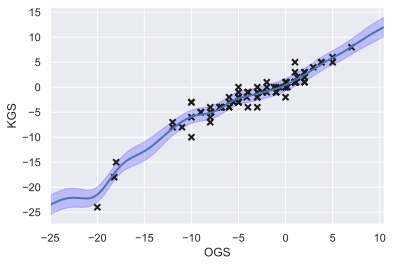

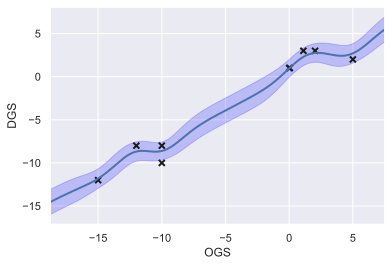

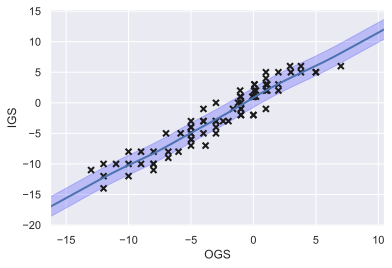

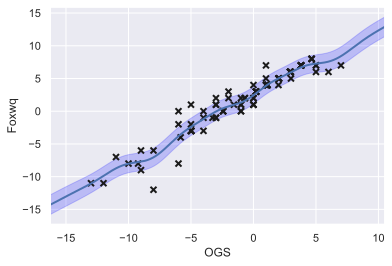

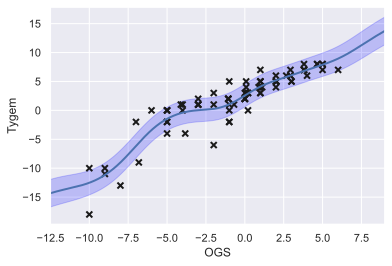

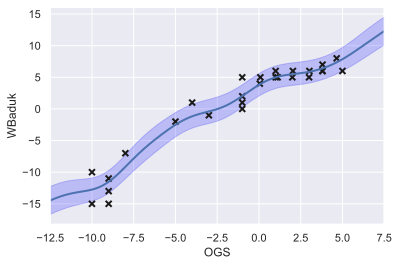

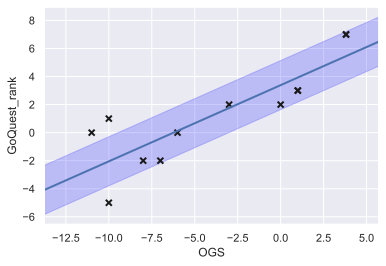

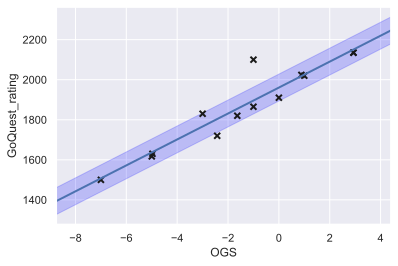

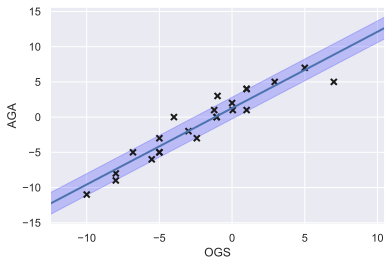

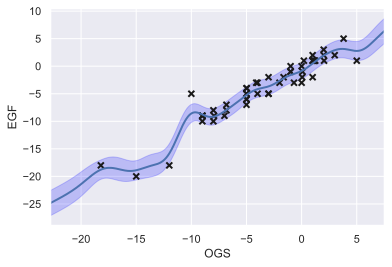

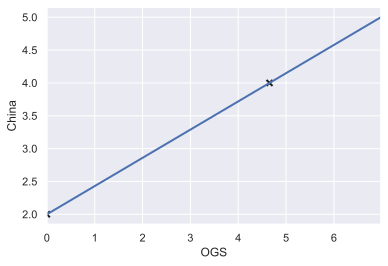

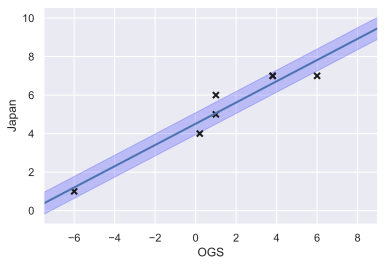

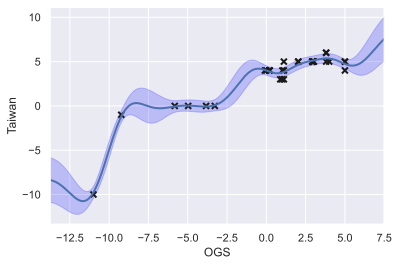

In [18]:
#%%capture --no-display
a='OGS'
mt1,st1,ct1=get_rank_tables(against=a, prior=(gpr_ls_prior,gpr_ls_prior-gpr_ls_prior_delta))

In [19]:
cols = ['KGS','OGS','IGS','Foxwq','Tygem','WBaduk','DGS','GoQuest_rating', 'GoQuest_rank','EGF','AGA','Taiwan','Japan','China',]
print(cols)
#print(numerical_rank_predict.columns)
#print(sorted_cols)

['KGS', 'OGS', 'IGS', 'Foxwq', 'Tygem', 'WBaduk', 'DGS', 'GoQuest_rating', 'GoQuest_rank', 'EGF', 'AGA', 'Taiwan', 'Japan', 'China']


## A table of rounded mean ranks

In [20]:
mt1[cols].set_index(a)

KGS  IGS Foxwq Tygem WBaduk  DGS GoQuest_rating GoQuest_rank  EGF  AGA  \
OGS                                                                           
27k  25k  29k   25k   33k    34k  21k            212          11k  29k  28k   
26k  24k  28k   24k   31k    33k  20k            277          11k  28k  27k   
25k  24k  26k   23k   30k    31k  19k            342          10k  27k  26k   
24k  23k  25k   22k   29k    30k  19k            407          10k  26k  25k   
23k  22k  24k   21k   27k    29k  18k            471           9k  25k  24k   
22k  22k  23k   20k   26k    27k  17k            536           9k  24k  23k   
21k  22k  22k   19k   25k    26k  16k            601           8k  23k  21k   
20k  21k  21k   18k   24k    24k  15k            666           7k  21k  20k   
19k  19k  20k   17k   22k    23k  15k            730           7k  20k  19k   
18k  17k  19k   16k   21k    22k  14k            795           6k  19k  18k   
17k  15k  18k   15k   20k    20k  13k            860           6k  19k  17k   
16k  14k  17k   14k   18k    19k  13k            925           5k  19k  16k   
15k  13k  16k   13k   17k    18k  12k            989           5k  19k  15k   
14k  11k  14k   12k   16k    16k  11k           1054           4k  18k  14k   
13k  10k  13k   11k   15k    15k   9k           1119           4k  18k  13k   
12k   8k  12k   10k   14k    14k   9k           1184           3k  16k  12k   
11k   7k  11k    9k   13k    13k   9k           1248           3k  12k  11k   
10k   6k  10k    8k   13k    13k   9k           1313           2k   9k  10k   
9k    5k   9k    8k   11k    12k   8k           1378           2k   9k   8k   
8k    5k   8k    7k    9k     9k   7k           1443           1k   9k   7k   
7k    4k   7k    6k    6k     7k   6k           1507           1d   8k   6k   
6k    3k   6k    4k    3k     4k   5k           1572           1d   7k   5k   
5k    2k   5k    2k    1k     3k   4k           1637           2d   5k   4k   
4k    2k   4k    1k    1d     1k   3k           1702           2d   4k   3k   
3k    1k   3k    1d    1d     1d   2k           1766           3d   4k   2k   
2k    1k   2k    2d    1d     1d   1k           1831           3d   3k   1k   
1k    1d   1d    2d    2d     3d   1d           1896           4d   2k   1d   
1d    1d   2d    3d    4d     5d   2d           1961           4d   1k   2d   
2d    2d   3d    5d    5d     6d   3d           2025           5d   2d   3d   
3d    3d   4d    6d    6d     6d   4d           2090           5d   3d   4d   
4d    5d   5d    7d    7d     7d   4d           2155           6d   4d   6d   
5d    6d   6d    8d    8d     8d   3d           2220           7d   4d   7d   
6d    7d   7d    8d    9d     9d   4d           2285           7d   4d   8d   
7d    8d   8d    9d   10d    11d   5d           2349           8d   5d   9d   
8d    9d   9d    9d   11d    12d   6d           2414           8d   6d  10d   

    Taiwan Japan China  
OGS                     
27k    18k   10k   10k  
26k    17k   10k    9k  
25k    16k    9k    9k  
24k    15k    9k    8k  
23k    15k    8k    8k  
22k    14k    8k    7k  
21k    13k    7k    7k  
20k    12k    7k    7k  
19k    12k    6k    6k  
18k    11k    5k    6k  
17k    10k    5k    5k  
16k     9k    4k    5k  
15k     9k    4k    4k  
14k     8k    3k    4k  
13k     9k    3k    4k  
12k    11k    2k    3k  
11k    10k    2k    3k  
10k     5k    1k    2k  
9k      1k    1d    2k  
8k      1d    1d    1k  
7k      1d    2d    1k  
6k      1d    2d    1k  
5k      1d    3d    1d  
4k      1d    3d    1d  
3k      1d    4d    2d  
2k      3d    4d    2d  
1k      5d    5d    3d  
1d      5d    6d    3d  
2d      5d    6d    3d  
3d      6d    7d    4d  
4d      6d    7d    4d  
5d      6d    8d    5d  
6d      6d    8d    5d  
7d      6d    9d    6d  
8d      8d    9d    6d

## A table of rounded +/- 1 standard deviation of ranks

In [21]:
st1[cols].set_index(a)

KGS        IGS      Foxwq      Tygem     WBaduk        DGS  \
OGS                                                                     
27k  27k - 24k  30k - 27k  27k - 24k  35k - 30k  36k - 32k  22k - 19k   
26k  26k - 23k  29k - 26k  26k - 23k  34k - 29k  35k - 30k  22k - 19k   
25k  25k - 22k  28k - 25k  25k - 22k  32k - 28k  33k - 29k  21k - 18k   
24k  25k - 21k  27k - 24k  24k - 21k  31k - 26k  32k - 28k  20k - 17k   
23k  24k - 20k  26k - 23k  23k - 20k  30k - 25k  31k - 26k  19k - 16k   
22k  24k - 20k  25k - 22k  22k - 19k  29k - 24k  29k - 25k  18k - 16k   
21k  24k - 21k  24k - 21k  21k - 18k  27k - 22k  28k - 24k  18k - 15k   
20k  23k - 20k  23k - 19k  20k - 17k  26k - 21k  27k - 22k  17k - 14k   
19k  21k - 18k  22k - 18k  19k - 16k  25k - 20k  25k - 21k  16k - 13k   
18k  18k - 15k  21k - 17k  18k - 15k  23k - 19k  24k - 20k  15k - 13k   
17k  16k - 13k  19k - 16k  17k - 14k  22k - 17k  23k - 18k  15k - 12k   
16k  16k - 12k  18k - 15k  16k - 13k  21k - 16k  21k - 17k  14k - 11k   
15k  15k - 11k  17k - 14k  15k - 12k  20k - 15k  20k - 16k  13k - 11k   
14k  13k - 10k  16k - 13k  14k - 11k  18k - 13k  19k - 14k   12k - 9k   
13k   11k - 8k  15k - 12k  12k - 10k  17k - 12k  17k - 13k   11k - 8k   
12k   10k - 7k  14k - 11k   11k - 8k  16k - 12k  16k - 12k   10k - 8k   
11k    8k - 6k  13k - 10k   10k - 7k  16k - 11k  15k - 11k   10k - 8k   
10k    7k - 5k   12k - 9k    9k - 7k  15k - 10k  15k - 11k   10k - 8k   
9k     7k - 4k   11k - 8k    9k - 6k   13k - 9k  13k - 10k    9k - 7k   
8k     6k - 4k   10k - 7k    8k - 6k   11k - 7k   11k - 7k    8k - 5k   
7k     6k - 3k    9k - 6k    7k - 4k    8k - 4k    9k - 5k    7k - 4k   
6k     4k - 2k    8k - 4k    5k - 2k    5k - 1k    6k - 2k    6k - 3k   
5k     3k - 1k    7k - 3k    4k - 1k    3k - 2d    4k - 1k    5k - 2k   
4k     3k - 1d    5k - 2k    3k - 1d    2k - 3d    3k - 2d    5k - 2k   
3k     3k - 1d    4k - 1k    1k - 2d    2k - 3d    2k - 2d    4k - 1k   
2k     2k - 1d    3k - 1d    1k - 3d    2k - 3d    1k - 3d    3k - 1d   
1k     2k - 2d    2k - 2d    1d - 4d    1k - 4d    1d - 5d    2k - 2d   
1d     1k - 3d    1k - 3d    2d - 5d    2d - 6d    3d - 7d    1d - 3d   
2d     1d - 4d    1d - 5d    4d - 6d    3d - 7d    4d - 8d    2d - 4d   
3d     2d - 5d    2d - 6d    5d - 7d    4d - 8d    5d - 8d    3d - 5d   
4d     3d - 6d    4d - 7d    6d - 8d    5d - 9d    5d - 9d    2d - 5d   
5d     4d - 7d    4d - 8d    7d - 9d   6d - 10d    6d - 9d    2d - 5d   
6d     5d - 8d    5d - 9d   7d - 10d   7d - 11d   7d - 11d    3d - 5d   
7d     6d - 9d   6d - 10d   7d - 10d   8d - 12d   9d - 13d    3d - 6d   
8d    8d - 11d   8d - 11d   8d - 11d    9d - 13   10d - 14    4d - 7d   

    GoQuest_rating GoQuest_rank        EGF        AGA     Taiwan      Japan  \
OGS                                                                           
27k      145 - 280    13k - 10k  32k - 27k  30k - 26k  20k - 15k  11k - 10k   
26k      210 - 344     12k - 9k  31k - 26k  28k - 25k  19k - 14k   10k - 9k   
25k      275 - 409     12k - 8k  29k - 25k  27k - 24k  19k - 14k   10k - 9k   
24k      340 - 474     11k - 8k  28k - 24k  26k - 23k  18k - 13k    9k - 8k   
23k      404 - 539     11k - 7k  27k - 23k  25k - 22k  17k - 12k    9k - 8k   
22k      469 - 603     10k - 7k  26k - 22k  24k - 21k  16k - 11k    8k - 7k   
21k      534 - 668     10k - 6k  25k - 21k  23k - 20k  16k - 11k    8k - 6k   
20k      599 - 733      9k - 6k  24k - 19k  22k - 19k  15k - 10k    7k - 6k   
19k      663 - 798      9k - 5k  22k - 18k  21k - 18k   14k - 9k    7k - 5k   
18k      728 - 862      8k - 5k  20k - 17k  20k - 17k   13k - 8k    6k - 5k   
17k      793 - 927      8k - 4k  21k - 16k  19k - 16k   13k - 8k    5k - 4k   
16k      858 - 992      7k - 4k  21k - 17k  18k - 15k   12k - 7k    5k - 4k   
15k     922 - 1057      7k - 3k  21k - 17k  17k - 13k   11k - 6k    4k - 3k   
14k     987 - 1121      6k - 2k  20k - 16k  15k - 12k   11k - 6k    4k - 3k   
13k    1052 - 1186      5k - 2k  20k - 16k  1

## A combined table of mean and standard deviation of ranks

In [22]:
ct1[cols].set_index(a)

KGS          IGS        Foxwq        Tygem       WBaduk  \
OGS                                                                    
27k  25.5k ± 1.9  28.7k ± 1.6  25.2k ± 1.5  32.6k ± 2.4  33.9k ± 2.2   
26k  24.5k ± 1.9  27.6k ± 1.6  24.2k ± 1.5  31.3k ± 2.4  32.6k ± 2.2   
25k  23.5k ± 1.9  26.5k ± 1.6  23.2k ± 1.5  30.0k ± 2.4  31.2k ± 2.2   
24k  22.7k ± 1.9  25.4k ± 1.6  22.2k ± 1.5  28.7k ± 2.4  29.9k ± 2.2   
23k  22.2k ± 1.9  24.3k ± 1.6  21.1k ± 1.5  27.5k ± 2.4  28.5k ± 2.2   
22k  22.2k ± 1.9  23.2k ± 1.6  20.1k ± 1.5  26.2k ± 2.4  27.2k ± 2.2   
21k  22.3k ± 1.7  22.1k ± 1.6  19.1k ± 1.5  24.9k ± 2.4  25.8k ± 2.2   
20k  21.5k ± 1.5  21.1k ± 1.6  18.1k ± 1.5  23.6k ± 2.4  24.5k ± 2.2   
19k  19.3k ± 1.5  20.0k ± 1.6  17.1k ± 1.5  22.3k ± 2.4  23.1k ± 2.2   
18k  16.8k ± 1.4  18.9k ± 1.6  16.1k ± 1.5  21.0k ± 2.4  21.8k ± 2.2   
17k  14.9k ± 1.6  17.8k ± 1.6  15.0k ± 1.5  19.7k ± 2.4  20.4k ± 2.2   
16k  13.8k ± 1.8  16.7k ± 1.6  14.0k ± 1.5  18.4k ± 2.4  19.1k ± 2.2   
15k  12.8k ± 1.9  15.6k ± 1.6  13.0k ± 1.5  17.1k ± 2.4  17.7k ± 2.2   
14k  11.5k ± 1.8  14.5k ± 1.6  12.1k ± 1.5  15.9k ± 2.4  16.4k ± 2.2   
13k   9.9k ± 1.6  13.3k ± 1.6  11.0k ± 1.4  14.8k ± 2.4  15.1k ± 2.2   
12k   8.3k ± 1.4  12.2k ± 1.6   9.9k ± 1.4  13.9k ± 2.4  13.9k ± 2.2   
11k   6.9k ± 1.4  11.2k ± 1.6   8.7k ± 1.4  13.3k ± 2.2  13.2k ± 2.0   
10k   5.9k ± 1.3  10.2k ± 1.6   8.0k ± 1.4  12.5k ± 2.1  12.8k ± 1.8   
9k    5.5k ± 1.3   9.3k ± 1.6   7.7k ± 1.4  11.2k ± 2.1  11.5k ± 1.8   
8k    5.1k ± 1.3   8.3k ± 1.6   7.0k ± 1.4   9.0k ± 2.1   9.2k ± 1.9   
7k    4.3k ± 1.3   7.2k ± 1.6   5.6k ± 1.4   6.2k ± 2.1   6.6k ± 2.0   
6k    3.1k ± 1.3   6.1k ± 1.6   3.8k ± 1.3   3.4k ± 2.0   4.4k ± 2.0   
5k    2.2k ± 1.3   4.9k ± 1.6   2.4k ± 1.3   1.5k ± 2.0   2.5k ± 1.9   
4k    1.8k ± 1.3   3.8k ± 1.6   1.2k ± 1.3   0.4k ± 2.0   1.2k ± 1.9   
3k    1.3k ± 1.3   2.7k ± 1.6   1.0d ± 1.3   1.0d ± 2.0   0.4k ± 1.9   
2k    0.8k ± 1.3   1.6k ± 1.6   1.7d ± 1.3   1.3d ± 2.0   1.5d ± 1.9   
1k    0.3k ± 1.3   0.4k ± 1.6   2.3d ± 1.3   2.0d ± 2.0   3.0d ± 1.8   
1d    1.4d ± 1.3   1.8d ± 1.6   3.4d ± 1.3   3.6d ± 2.0   4.8d ± 1.8   
2d    2.4d ± 1.3   3.0d ± 1.6   4.9d ± 1.3   5.1d ± 2.0   6.0d ± 1.8   
3d    3.5d ± 1.3   4.1d ± 1.6   6.0d ± 1.3   6.2d ± 2.0   6.5d ± 1.8   
4d    4.6d ± 1.3   5.1d ± 1.6   7.0d ± 1.3   7.1d ± 2.0   6.9d ± 1.8   
5d    5.9d ± 1.4   6.1d ± 1.6   7.8d ± 1.3   8.0d ± 2.0   7.6d ± 1.8   
6d    6.9d ± 1.4   7.0d ± 1.6   8.3d ± 1.3   8.9d ± 2.0   8.9d ± 1.9   
7d    7.9d ± 1.5   8.1d ± 1.6   8.6d ± 1.4  10.0d ± 2.1  10.6d ± 2.0   
8d    9.1d ± 1.5   9.1d ± 1.6   9.4d ± 1.4  11.4d ± 2.3  12.4d ± 2.2   

             DGS GoQuest_rating GoQuest_rank          EGF          AGA  \
OGS                                                                      
27k  20.9k ± 1.4   212.5 ± 67.1  11.3k ± 1.8  29.3k ± 2.3  28.0k ± 1.5   
26k  20.1k ± 1.4   277.2 ± 67.1  10.7k ± 1.8  28.2k ± 2.3  26.9k ± 1.5   
25k  19.3k ± 1.4   342.0 ± 67.1  10.2k ± 1.8  27.2k ± 2.3  25.8k ± 1.5   
24k  18.6k ± 1.4   406.7 ± 67.1   9.7k ± 1.8  26.1k ± 2.3  24.8k ± 1.5   
23k  17.8k ± 1.4   471.5 ± 67.1   9.1k ± 1.8  25.1k ± 2.3  23.7k ± 1.5   
22k  17.0k ± 1.4   536.2 ± 67.1   8.6k ± 1.8  24.0k ± 2.3  22.6k ± 1.5   
21k  16.3k ± 1.4   601.0 ± 67.1   8.0k ± 1.8  22.8k ± 2.3  21.5k ± 1.5   
20k  15.5k ± 1.4   665.7 ± 67.1   7.5k ± 1.8  21.4k ± 2.2  20.4k ± 1.5   
19k  14.7k ± 1.4   730.5 ± 67.1   6.9k ± 1.8  19.8k ± 1.9  19.3k ± 1.5   
18k  14.0k ± 1.4   795.2 ± 67.1   6.4k ± 1.8  18.6k ± 1.8  18.2k ± 1.5   
17k  13.3k ± 1.4   860.0 ± 67.1   5.8k ± 1.8  18.5k ± 2.0  17.2k ± 1.5   
16k  12.6k ± 1.3   924.7 ± 67.1   5.3k ± 1.8  18.9k ± 2.0  16.1k ± 1.5   
15k  11.8k ± 1.1   989.5 ± 67.1   4.8k ± 1.8  18.9k ± 1.8  15.0k ± 1.5   
14k  10.7k ± 1.2  1054.2 ± 67.1   4.2k ± 1.8  18.3k ± 2.0  13.9k ± 1.5   
13k   9.5k ± 1.2  1119.0 ± 67.1   3.7k ± 1.8  17.7k ± 2.0  12.8k ± 1.5   
12k   8.7k ± 1.1  1183.7 ± 67.1   3.1k ± 1.8  15.8k ± 1.7  11.7k ± 1.5   
11k   8.7k ± 1.1